# Imports

In [1]:
import numpy as np
import scipy
from scipy.stats import unitary_group

In [2]:
import seaborn as sns
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.colormaps['cool']

In [4]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import jacfwd, jacrev

# Choose device : GPUs or CPU

In [5]:
!nvidia-smi

Tue Aug 15 12:21:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100S-PCI...  Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   

If the above returns an issue choose CPU otherwise choose GPU, and select the kdevice with the most RAM.

In [6]:
ENV_DEV = 'GPU'
# ENV_DEV = 'CPU'
assert ENV_DEV=='GPU' or ENV_DEV=='CPU'

In [7]:
if ENV_DEV == 'GPU':
    gpus = jax.devices('gpu')
    print(gpus)
    print("choose GPU here")
    dev = gpus[3]
elif ENV_DEV == 'CPU':
    cpus = jax.devices('cpu')
    print(cpus)
    print("chooseCPU here")
    dev = cpus[0]
print(dev)

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=2, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=3, process_index=0, slice_index=0)]
choose GPU here
gpu:3


# Define Functions

run everything and check that all tests are passed successfully and that the precisions are small enough

In [8]:
def Paulis():
    I = np.array([[+1,+0],[+0,+1]])
    X = np.array([[+0,+1],[+1,+0]])
    Y = np.array([[+0,-1j],[+1j,+0]])
    Z = np.array([[+1,+0],[+0,-1]])
    return I,X,Y,Z

In [9]:
def eigvalstopoly(eigvals,deg):
    r"""transforms eigenvalues into polynomials

    Args:
        eigvals [n]: array of integer eigenvalues values usually 2 to the number of qubits
        deg: max degree covered

    Returns:
        poly: [n,2*deg+1] : eigenvalues as polynomials
    """
    poly = np.zeros((eigvals.size,2*deg+1))
    for k,eigval in enumerate(eigvals):
        poly[k,int(np.round(eigval+deg))] = 1
        # poly.at[k,int(jnp.round(eigval+deg))].set(1)
    return poly

In [10]:
def test_eigvalstopoly():
    eigvals_test = np.array([-2,0,3])
    result = np.array([[0., 0., 1., 0., 0., 0., 0., 0., 0.],[0., 0., 0., 0., 1., 0., 0., 0., 0.],[0., 0., 0., 0., 0., 0., 0., 1., 0.]])
    assert np.allclose(eigvalstopoly(eigvals_test,deg=4),result)

test_eigvalstopoly()

In [11]:
def polytokernel(P,deg=None):
    r"""transforms polynomials into convolving kernels

    Args:
        P [n,deg]: array of integer eigenvalues values usually 2 to the number of qubits
        deg: max degree covered

    Returns:
        poly: [n,2*deg+1] : eigenvalues as polynomials
    """
    if deg is None:
        deg = (P.shape[1]-1)//2
    MP = np.zeros((P.shape[0],2*deg+1,2*deg+1))
    for k in reversed(range(1,deg+1)):
        MP[:,:,deg-k] = np.concatenate([P[:,k:],np.zeros((P.shape[0],k))],axis=1)
    MP[:,:,deg] = P
    for k in range(1,deg+1):
        MP[:,:,deg+k] = np.concatenate([np.zeros((P.shape[0],k)),P[:,:-k]],axis=1)
    return MP

In [12]:
def test_polytokernel():
    p1 = np.array([0,0,1,5,-1,0,0])
    p2 = np.array([0,0,-2,1,2,0,0])
    P = np.stack([p1,p2])
    MP = polytokernel(P)
    
    q = np.array([0,0,2,1,5,0,0])
    
    p1q_a = MP[0] @ q
    p1q_b = np.convolve(p1,q, mode='same')
    p2q_a = MP[1] @ q
    p2q_b = np.convolve(p2,q, mode='same')
    
    assert np.allclose(p1q_a,p1q_b)
    assert np.allclose(p2q_a,p2q_b)

test_polytokernel()

In [13]:
def apply_conv(MP,state):
    return jnp.einsum('ijk,ik->ij',MP,state)

In [14]:
def test_applyconv():
    states = jnp.stack([np.array([[0,0,1,0,-1,0,0],[0,0,0,2,0,0,0],[0,0,1,2,3,0,0],[0,0,5,0,0,0,0]])]*10,axis=2)
    p1 = np.array([0,0,1,5,-1,0,0])
    p2 = np.array([0,0,-2,1,2,0,0])
    P = np.stack([p1,p2,p1,p2])
    MP = polytokernel(P)
    _fun = lambda state : apply_conv(MP,state)
    test_res = jit(vmap(_fun), device = dev)(states.transpose([2,0,1]))
    
    for k in range(4):
        ta = np.convolve(P[k],states[k,:,0], mode='same')
        tb = test_res[k,k,:]
        assert np.allclose(ta,tb)

test_applyconv()

In [15]:
def eval_trigpoly(P,xs):
    deg = (P.size-1)//2
    eikx = np.exp(1j*np.einsum('i,j->ij',np.arange(-deg,deg+1),xs))
    return np.einsum('i,ij->j',P,eikx)

In [16]:
def test_eval_trigpoly():
    P = np.array([0,1,2,3,0])
    xs = np.linspace(-np.pi,np.pi, 10)
    ta = eval_trigpoly(P,xs)
    tb = np.exp(-xs*1j) + 2 + 3 * np.exp(xs*1j)
    
    assert np.allclose(ta,tb)

test_eval_trigpoly()

In [17]:
def test_trigpoly():
    xs = np.linspace(-np.pi,np.pi)
    
    p1 = np.array([0,0,1,4,-1,0,0]) # 4 - i 2sx
    p2 = np.array([0,0,2,1,2,0,0]) # 1 + 4cx
    q = np.convolve(p1,p2, mode='same') # [ 0  2  9  4  7 -2  0] 4 + 16cx -2isx -i8sxcx
    
    ys1 = eval_trigpoly(p1,xs)
    ys2 = eval_trigpoly(p2,xs)
    ysq = eval_trigpoly(q,xs)
    
    assert np.allclose(ys1*ys2,ysq)
    
    
    # plt.subplot(2,1,1)
    # plt.plot(xs,ys1.real)
    # plt.plot(xs,ys2.real)
    # plt.plot(xs, 1 + 4 * np.cos(xs),'k--')
    # plt.plot(xs,ysq.real)
    
    # plt.subplot(2,1,2)
    # plt.plot(xs,ys1.imag)
    # plt.plot(xs,- 2 * np.sin(xs),'k--')
    # plt.plot(xs,ys2.imag)
    # plt.plot(xs,ysq.imag)
    # plt.plot(xs,- 2 * np.sin(xs) - 8 * np.sin(xs) * np.cos(xs),'k--')
    # plt.plot(xs,(ys1*ys2).imag,'r:')

test_trigpoly()

In [18]:
def tosincos(statef):
    d = statef.shape[0]
    sf = jnp.convolve(statef[:],jnp.conjugate(statef[::-1]))
    assert jnp.allclose(sf[:,1::2],0)
    return jnp.concatenate([sf[d-1:d].real,2*sf[d+1::2].real,2*sf[d+1::2].imag])

In [19]:
def test_tosincos():
    p1 = np.array([0,0,1,4,-1,0,0]) # 4 - i 2sx : 16 + 4 sx**2 
    # sx**2 = 0.5*(1-cos(2x))
    # [16+2, -2, 0]
    assert np.allclose(tosincos(p1),np.array([16+2, -2, 0,0,0,0,0]))

In [20]:
def eval_several_scpoly(Ps,xs):
    deg = (Ps.shape[0]-1)//2
    # a0 = P[0]
    # ck = P[1:deg+1]
    # sk = P[deg+1:]
    coskx = [np.cos(2*xs*k) for k in range(1,deg+1)]
    sinkx = [np.sin(2*xs*k) for k in range(1,deg+1)]
    
    sckx = np.concatenate([np.array([xs*0+1]),np.array(coskx),np.array(sinkx)])

    return np.einsum('ik,ij->kj',Ps,sckx)

In [21]:
def dot(state1,state2):
    s = 0
    d = state1.shape[1]
    
    for k in range(state1.shape[0]):
        sf = jnp.convolve(state1[k,:],jnp.conjugate(state2[k,::-1]))
        s +=  jnp.concatenate([sf[d-1:d].real,2*sf[d+1::2].real,2*sf[d+1::2].imag])
    return s

In [22]:
def thes_state(A,Bs,numlayers,thes):
    N = A.shape[0]
    
    eigA, SA = np.linalg.eigh(A)
    dA = int(np.round(np.max(np.abs(eigA))))
    
    eigBs = []
    SBs = []
    
    for B in Bs:
        eigB, SB = np.linalg.eigh(B)
        eigBs.append(eigB)
        SBs.append(SB)
        
    deg = dA * numlayers # no margin
    
    MPA = polytokernel(eigvalstopoly(eigA,deg))
    
    states = []
    
    #init
    state = np.zeros([N,2*deg+1])
    state[0,deg] = 1
    state_jnp = jnp.array(state)

    k_init = 0
    for k in range(numlayers): #go to A basis
        
        state_jnp = jnp.einsum('ij,jk->ik',np.conjugate(SA.T),state_jnp) #change basis to A
        state_jnp = jnp.einsum('ijk,ik->ij',MPA,state_jnp) #convolution with generator A
        state_jnp = jnp.einsum('ij,jk->ik',SA,state_jnp) #change basis to I
        
        for ind_b in range(len(Bs)):
            eigB = eigBs[ind_b]
            SB = SBs[ind_b]            
            state_jnp = jnp.einsum('ij,jk->ik',np.conjugate(SB.T),state_jnp) #change basis to B
            eithB = jnp.exp(1j*eigB*thes[k_init])
            k_init += 1
            state_jnp = jnp.einsum('i,ij->ij',eithB,state_jnp) # apply B parameter
            state_jnp = jnp.einsum('ij,jk->ik',SB,state_jnp) #change basis to I

        states.append(state_jnp)
        # print(f"{k} out of {numlayers}")
    
    return jnp.stack(states)

In [23]:
def test_thes_state():
    I,X,Y,Z = Paulis()
    A = (np.kron(np.kron(np.kron(X,I),I),I) + np.kron(np.kron(np.kron(I,X),I),I) + np.kron(np.kron(np.kron(I,I),X),I) + np.kron(np.kron(np.kron(I,I),I),X))/2
    B = np.kron(np.kron(np.kron(Y,Y),I),I) + np.kron(np.kron(np.kron(I,I),Y),Y) + np.kron(np.kron(np.kron(I,Y),Y),I) + np.kron(np.kron(np.kron(Y,I),I),Y)
    Bs = [B]
    N = A.shape[0]
    
    xs = np.linspace(-np.pi,np.pi)
    thes = [0.5,0.6]

    #track 1
    states = thes_state(A,Bs,2,thes)
    Sa = np.array([eval_trigpoly(states[-1][k,:],xs) for k in range(N)]).T

    #track 2 
    def fun_x_thes(x):
        state = np.zeros([N])
        state[0] = 1
        ax = scipy.linalg.expm(1j*A*x)
        b1 = scipy.linalg.expm(1j*B*thes[0])
        b2 = scipy.linalg.expm(1j*B*thes[1])
        state = b2 @ ax @ b1 @ ax @ state 
        return state
    Sb = np.array([fun_x_thes(x) for x in xs])

    #compare
    # assert np.allclose(Sa,Sb)
    print(f"precision : {np.mean(np.abs(Sa-Sb))}")

test_thes_state()

precision : 3.4900761130931636e-08


In [24]:
def measurement(states,M):
    mstates = jnp.einsum('ij,kjl->kil',M,states)
    ms = []
    for j in range(states.shape[0]):
        m = dot(states[j],mstates[j])
        ms.append(m)
    return jnp.array(ms)

In [25]:
def test_measurement():
    I,X,Y,Z = Paulis()
    A = (np.kron(np.kron(np.kron(X,I),I),I) + np.kron(np.kron(np.kron(I,X),I),I) + np.kron(np.kron(np.kron(I,I),X),I) + np.kron(np.kron(np.kron(I,I),I),X))/2
    B = np.kron(np.kron(np.kron(Y,Y),I),I) + np.kron(np.kron(np.kron(I,I),Y),Y) + np.kron(np.kron(np.kron(I,Y),Y),I) + np.kron(np.kron(np.kron(Y,I),I),Y)
    Bs = [B]
    N = A.shape[0]
    
    xs = np.linspace(-np.pi,np.pi)
    thes = [0.5,0.6]
    
    #track 1
    states = thes_state(A,Bs,2,thes)
    ms = measurement(states,A)
    Sa = eval_several_scpoly(ms.T,xs)[1]
    
    #track 2 
    def fun_x_thes(x):
        state = np.zeros([N])
        state[0] = 1
        ax = scipy.linalg.expm(1j*A*x)
        b1 = scipy.linalg.expm(1j*B*thes[0])
        b2 = scipy.linalg.expm(1j*B*thes[1])
        state = b2 @ ax @ b1 @ ax @ state 
        return np.conjugate(state.T) @ A @ state
    Sb = np.array([fun_x_thes(x) for x in xs])
    
    print(f"precision : {np.mean(np.abs(Sa+Sb))}")

test_measurement()

precision : 8.578325775290829e-08


# Experiments

## Experiment 1
* A = (XIII + IXII + IIXI + IIIX)/2
* B1 = YYII + IIYY + IYYI + YIIY
* M = A

### Experiment definition

In [26]:
I,X,Y,Z = Paulis()
A = (np.kron(np.kron(np.kron(X,I),I),I) + np.kron(np.kron(np.kron(I,X),I),I) + np.kron(np.kron(np.kron(I,I),X),I) + np.kron(np.kron(np.kron(I,I),I),X))/2
B1 = np.kron(np.kron(np.kron(Y,Y),I),I) + np.kron(np.kron(np.kron(I,I),Y),Y) + np.kron(np.kron(np.kron(I,Y),Y),I) + np.kron(np.kron(np.kron(Y,I),I),Y)
Bs = [B1]
M = A/2

numlayers = 15
numthes = 10000

np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

### Check State Amplitude in the $e^{ix\pi}$ basis

In [27]:
fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)

In [28]:
states = fun_states(thes)
print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

The 16 complex amplitudes of the state vector for the 61 frequencies at the end of each of the 15 layers was sampled for 10000 instances of the circuit parameters


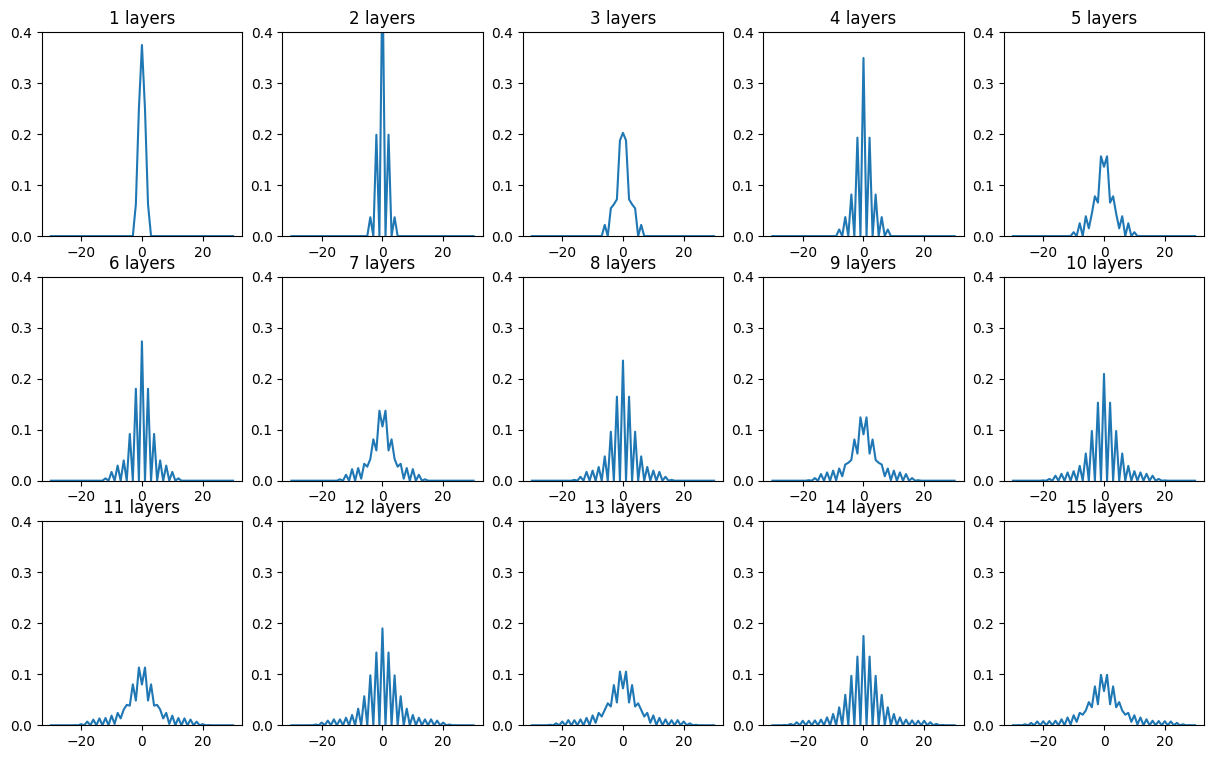

In [29]:
L = 30
x = np.arange(-L,L+1)
states_norm = np.sum(np.abs(states)**2,axis=2)

fig,axs = plt.subplots(3,5,figsize=(15,9))
for k,ax in enumerate(axs.flat):
    ax.plot(x,np.mean(states_norm[:,k,:],axis=0))
    ax.set_title(f"{k+1} layers")
    ax.set_ylim([0,0.4])

### Check output function in the $\cos(x\pi)$ and $\sin(x\pi)$ basis

In [30]:
def fun(thes):
    states =  thes_state(A,Bs,numlayers,thes)
    ms = measurement(states,M)
    return ms

fun_jnp = jit(vmap(fun),device=dev)

In [31]:
out_fun = fun_jnp(thes)
print(f"The output functions as cos sin decomposition represented by {out_fun.shape[2]} coefficient at the end of each of the {out_fun.shape[1]} layers was sampled for {out_fun.shape[0]} instances of the circuit parameters")

The output functions as cos sin decomposition represented by 61 coefficient at the end of each of the 15 layers was sampled for 10000 instances of the circuit parameters


In [32]:
std_abs = np.std(out_fun,axis=0)
max_abs = np.max(out_fun,axis=0)

Text(0, 0.5, 'std(coef)')

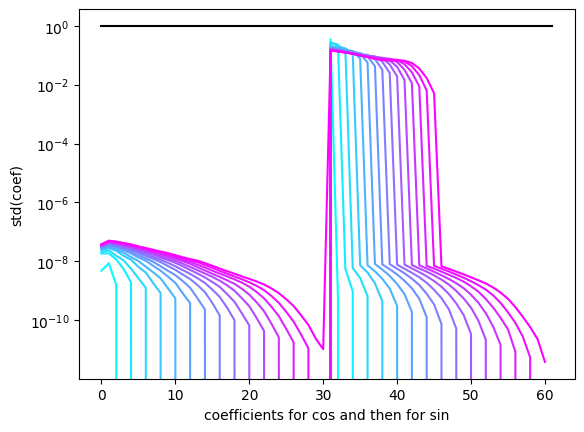

In [33]:
for k in range(numlayers):
    plt.semilogy(std_abs[k,:].T,c=cmap(k/(numlayers-1)))
plt.plot([0,out_fun.shape[2]],[1,1],'k')
plt.xlabel('coefficients for cos and then for sin')
plt.ylabel('std(coef)')

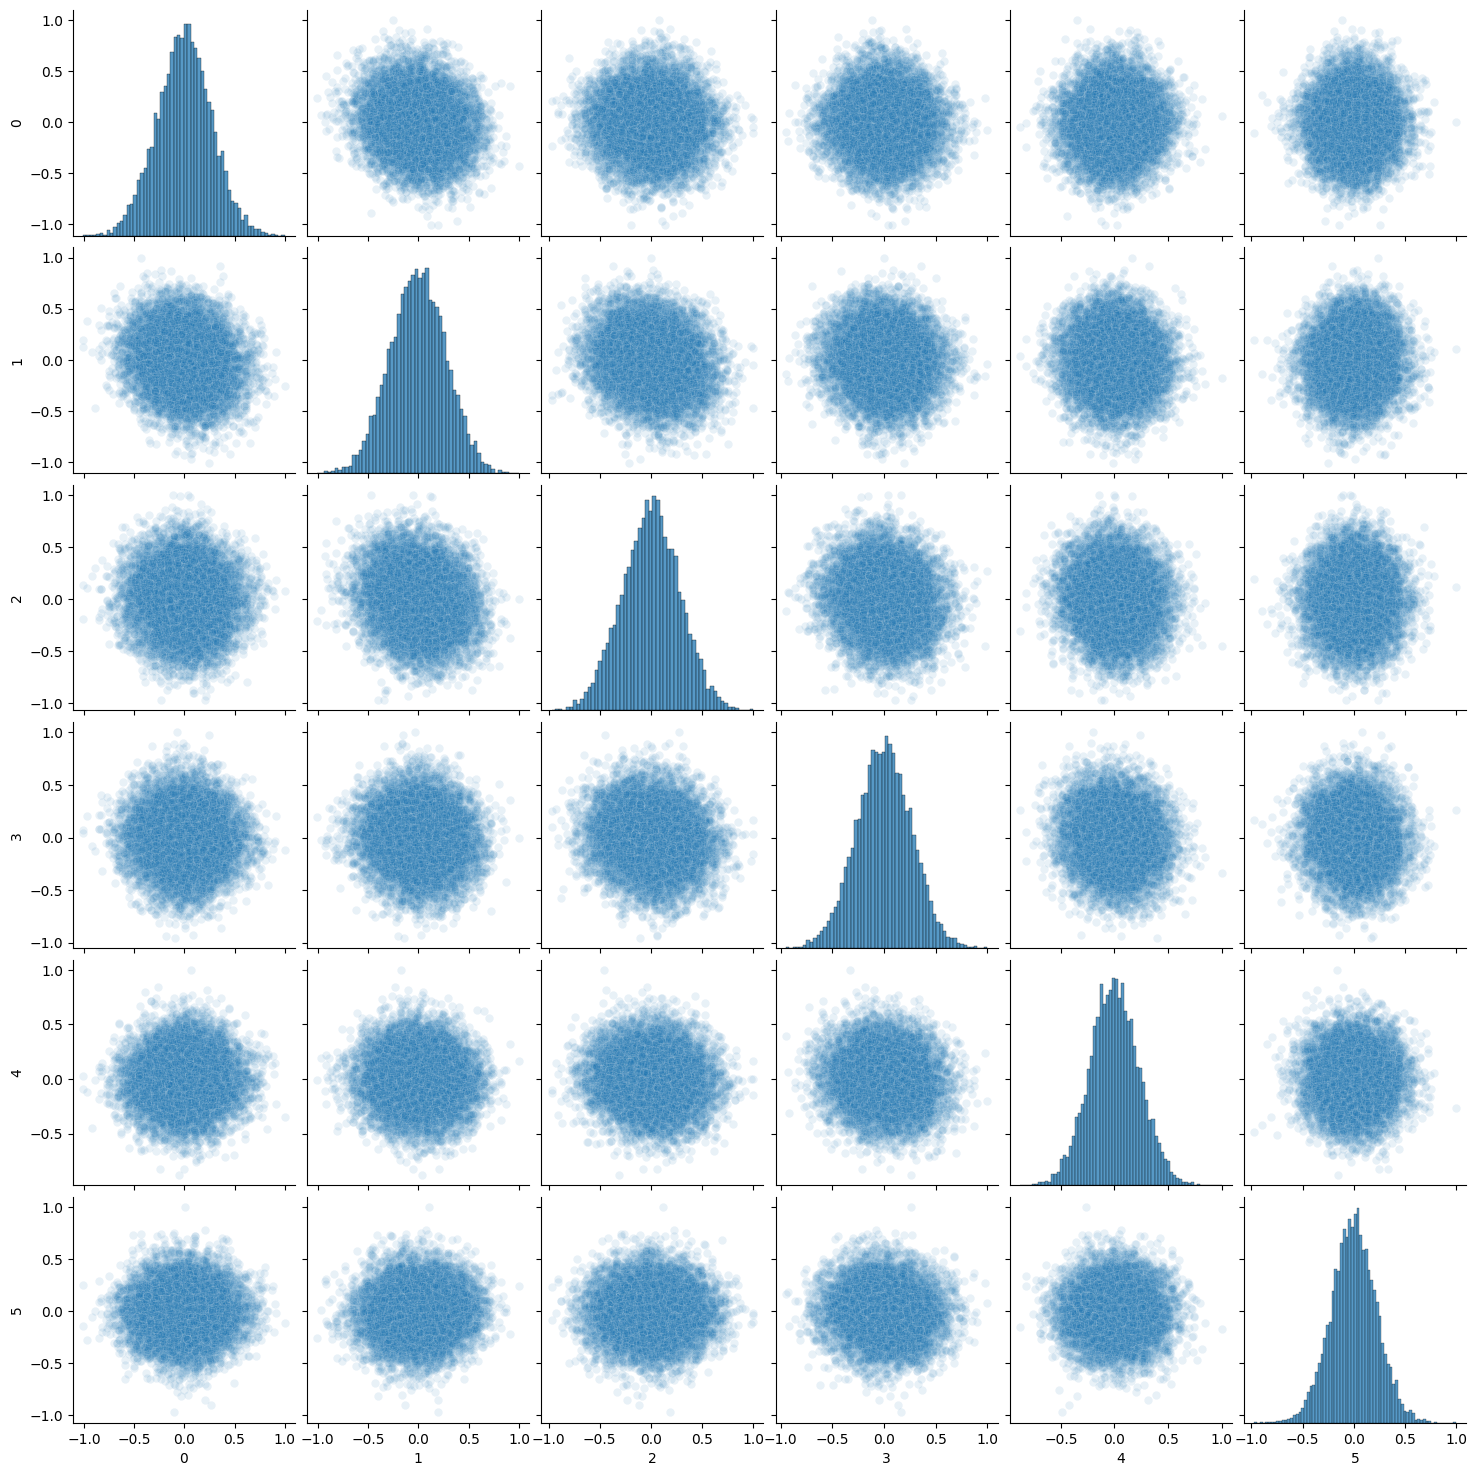

In [34]:
inds = list(range(31,37))
data = out_fun[:,10,inds].squeeze()
scale = np.max(data,axis=0)
data = data/scale
df = pd.DataFrame(data)
sns.pairplot(df,plot_kws={'alpha':0.1})

## Experiment 2
* A = XIII + IXII + IIXI + IIIXX
* B1 = YIII + IYII + IIYI + IIIY
* B2 = XIII + IXII + IIXI + IIIXX
* B3 = ZZII + IZZI + IIZZ + ZIIZ + ZIZI + IZIZ
* M = A

### Experiment definition

In [35]:
I,X,Y,Z = Paulis()
A = (np.kron(np.kron(np.kron(X,I),I),I) + np.kron(np.kron(np.kron(I,X),I),I) + np.kron(np.kron(np.kron(I,I),X),I) + np.kron(np.kron(np.kron(I,I),I),X))/2
B1 = np.kron(np.kron(np.kron(X,I),I),I) + np.kron(np.kron(np.kron(I,X),I),I) + np.kron(np.kron(np.kron(I,I),X),I) + np.kron(np.kron(np.kron(I,I),I),X)
B2 = np.kron(np.kron(np.kron(Y,I),I),I) + np.kron(np.kron(np.kron(I,Y),I),I) + np.kron(np.kron(np.kron(I,I),Y),I) + np.kron(np.kron(np.kron(I,I),I),Y)
B3 = np.kron(np.kron(np.kron(Z,Z),I),I) + np.kron(np.kron(np.kron(I,I),Z),Z) + np.kron(np.kron(np.kron(I,Z),Z),I) + np.kron(np.kron(np.kron(Z,I),I),Z) + np.kron(np.kron(np.kron(Z,I),Z),I) + np.kron(np.kron(np.kron(I,Z),I),Z)

Bs = [B1,B2,B3]
# Bs = [B1,B2,B3,B1,B2,B3]
M = A/2
N = A.shape[0]

numlayers = 15
numthes=10000
np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

### Check State Amplitude in the $e^{ix\pi}$ basis

In [36]:
fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)

In [37]:
states = fun_states(thes)
print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

The 16 complex amplitudes of the state vector for the 61 frequencies at the end of each of the 15 layers was sampled for 10000 instances of the circuit parameters


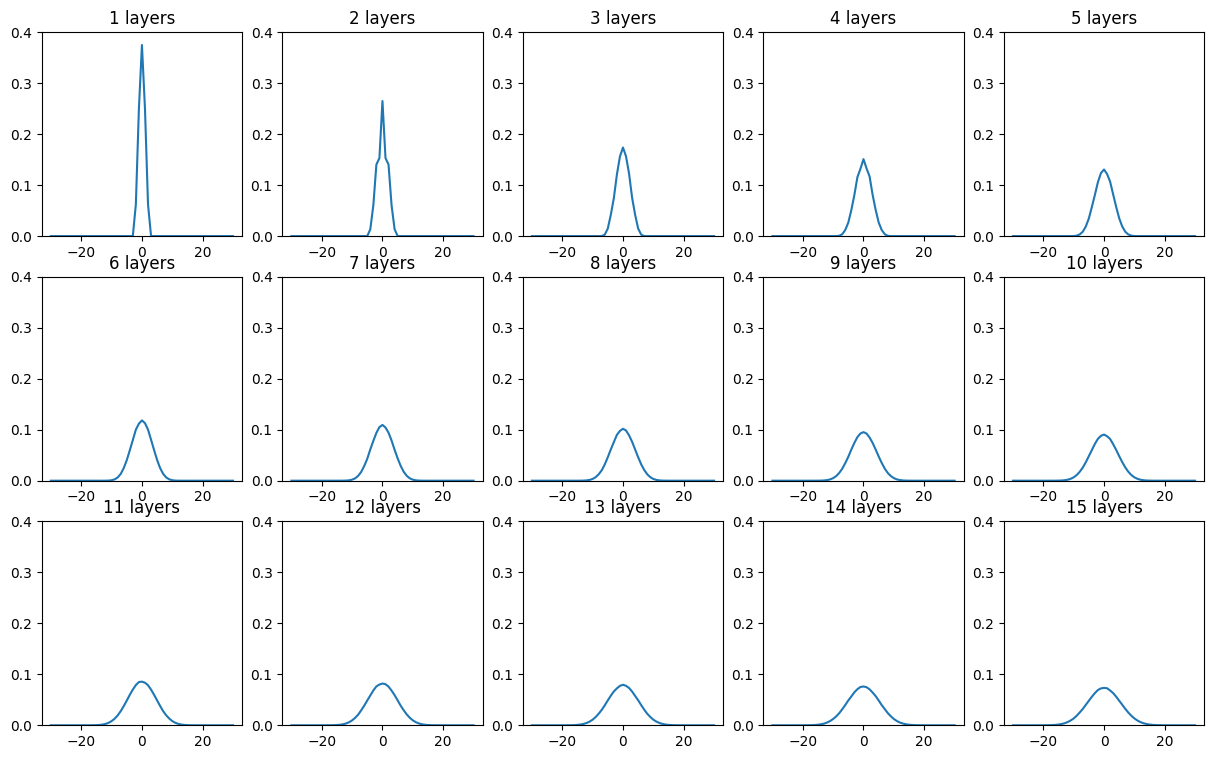

In [38]:
L = 30
x = np.arange(-L,L+1)
states_norm = np.sum(np.abs(states)**2,axis=2)

fig,axs = plt.subplots(3,5,figsize=(15,9))
for k,ax in enumerate(axs.flat):
    ax.plot(x,np.mean(states_norm[:,k,:],axis=0))
    ax.set_title(f"{k+1} layers")
    ax.set_ylim([0,0.4])

### Check output function in the $\cos(x\pi)$ and $\sin(x\pi)$ basis

In [39]:
def fun(thes):
    states =  thes_state(A,Bs,numlayers,thes)
    ms = measurement(states,M)
    return ms

fun_jnp = jit(vmap(fun),device=dev)

In [40]:
out_fun = fun_jnp(thes)
print(f"The output functions as cos sin decomposition represented by {out_fun.shape[2]} coefficient at the end of each of the {out_fun.shape[1]} layers was sampled for {out_fun.shape[0]} instances of the circuit parameters")

The output functions as cos sin decomposition represented by 61 coefficient at the end of each of the 15 layers was sampled for 10000 instances of the circuit parameters


In [41]:
std_abs = np.std(out_fun,axis=0)
max_abs = np.max(out_fun,axis=0)

Text(0, 0.5, 'std(coef)')

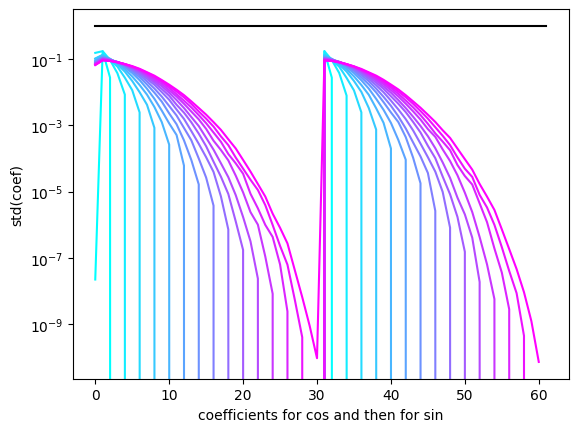

In [42]:
for k in range(numlayers):
    plt.semilogy(std_abs[k,:].T,c=cmap(k/(numlayers-1)))
plt.plot([0,out_fun.shape[2]],[1,1],'k')
plt.xlabel('coefficients for cos and then for sin')
plt.ylabel('std(coef)')

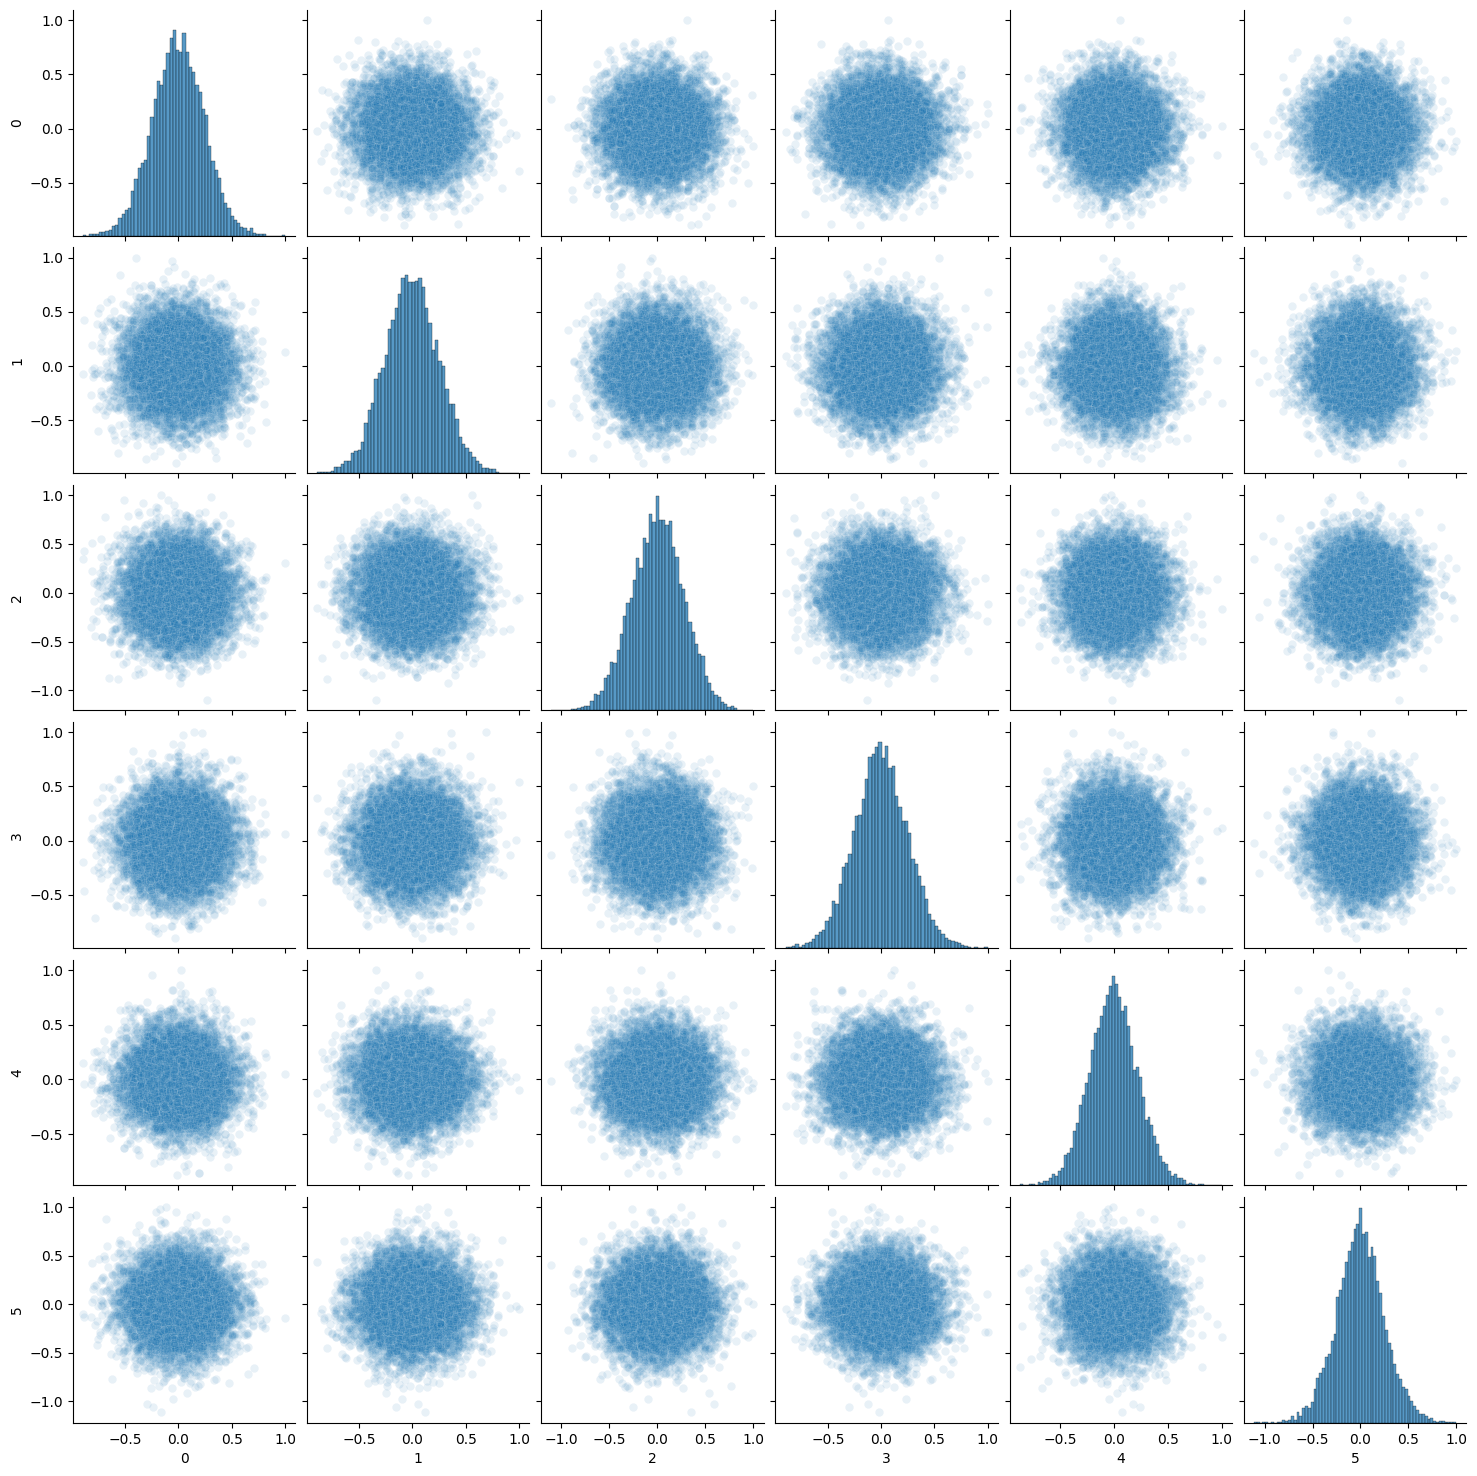

In [43]:
inds = list(range(31,37))
data = out_fun[:,10,inds].squeeze()
scale = np.max(data,axis=0)
data = data/scale
df = pd.DataFrame(data)
sns.pairplot(df,plot_kws={'alpha':0.1})

## Experiment 3
* A = XIII + IXII + IIXI + IIIX
* Bs : Haar random integer spectrum
* M = A

### Experiment definition

In [44]:
I,X,Y,Z = Paulis()
A = (np.kron(np.kron(np.kron(X,I),I),I) + np.kron(np.kron(np.kron(I,X),I),I) + np.kron(np.kron(np.kron(I,I),X),I) + np.kron(np.kron(np.kron(I,I),I),X))/2
Bs = []
for k in range(5):
    U = unitary_group.rvs(16,random_state=k)
    D = np.diag([-1]*8 + [1]*8)
    B = U @ D @ U.T.conj()
    Bs.append(B)

M = A/2
N = A.shape[0]

numlayers = 15
numthes=10000
np.random.seed(0)
thes = (np.random.rand(numthes,numlayers*len(Bs))-0.5)*np.pi

### Check State Amplitude in the $e^{ix\pi}$ basis

In [45]:
fun_states = jit(vmap(lambda thes : thes_state(A,Bs,numlayers,thes)),device=dev)

In [46]:
states = fun_states(thes)
print(f"The {states.shape[2]} complex amplitudes of the state vector for the {states.shape[3]} frequencies at the end of each of the {states.shape[1]} layers was sampled for {states.shape[0]} instances of the circuit parameters")

The 16 complex amplitudes of the state vector for the 61 frequencies at the end of each of the 15 layers was sampled for 10000 instances of the circuit parameters


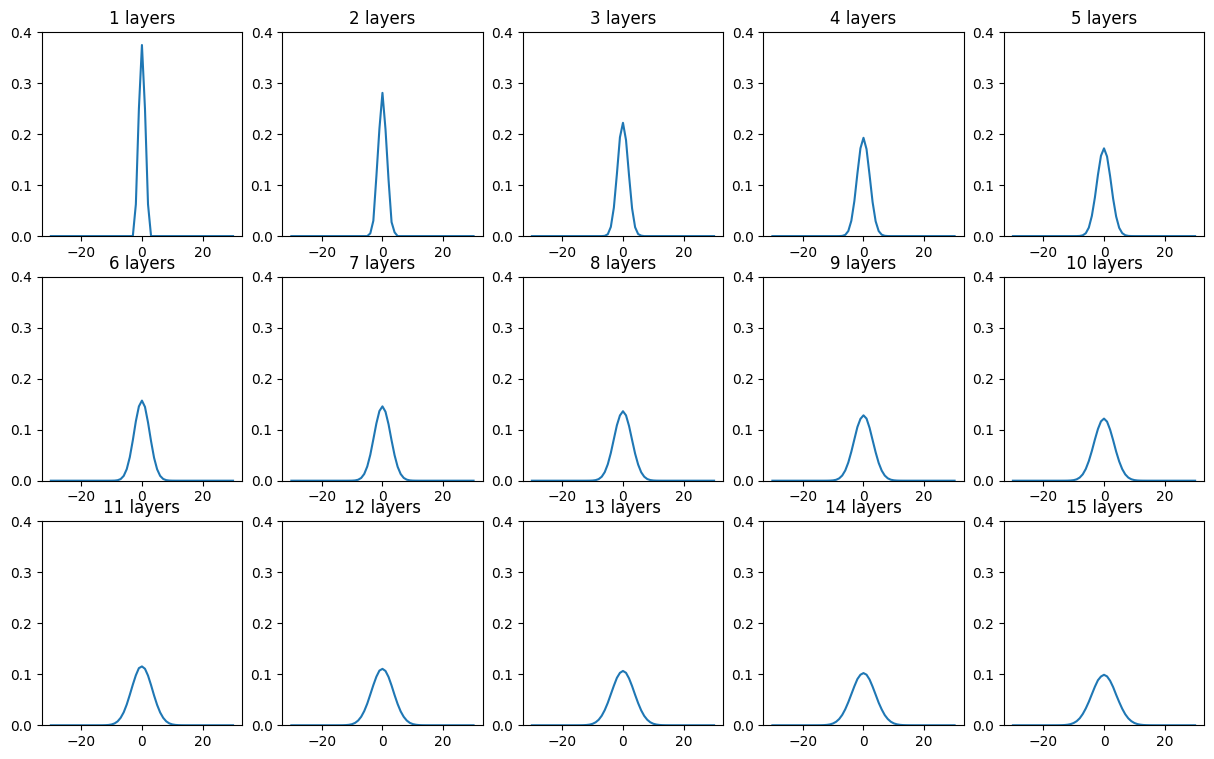

In [47]:
L = 30
x = np.arange(-L,L+1)
states_norm = np.sum(np.abs(states)**2,axis=2)

fig,axs = plt.subplots(3,5,figsize=(15,9))
for k,ax in enumerate(axs.flat):
    ax.plot(x,np.mean(states_norm[:,k,:],axis=0))
    ax.set_title(f"{k+1} layers")
    ax.set_ylim([0,0.4])

### Check output function in the $\cos(x\pi)$ and $\sin(x\pi)$ basis

In [48]:
def fun(thes):
    states =  thes_state(A,Bs,numlayers,thes)
    ms = measurement(states,M)
    return ms

fun_jnp = jit(vmap(fun),device=dev)

In [49]:
out_fun = fun_jnp(thes)
print(f"The output functions as cos sin decomposition represented by {out_fun.shape[2]} coefficient at the end of each of the {out_fun.shape[1]} layers was sampled for {out_fun.shape[0]} instances of the circuit parameters")

The output functions as cos sin decomposition represented by 61 coefficient at the end of each of the 15 layers was sampled for 10000 instances of the circuit parameters


In [50]:
std_abs = np.std(out_fun,axis=0)
max_abs = np.max(out_fun,axis=0)

Text(0, 0.5, 'std(coef)')

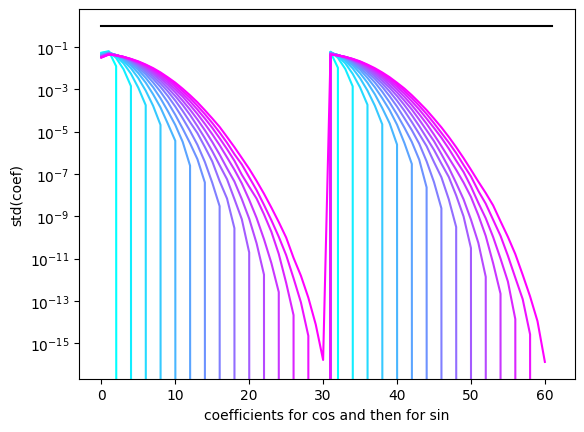

In [51]:
for k in range(numlayers):
    plt.semilogy(std_abs[k,:].T,c=cmap(k/(numlayers-1)))
plt.plot([0,out_fun.shape[2]],[1,1],'k')
plt.xlabel('coefficients for cos and then for sin')
plt.ylabel('std(coef)')

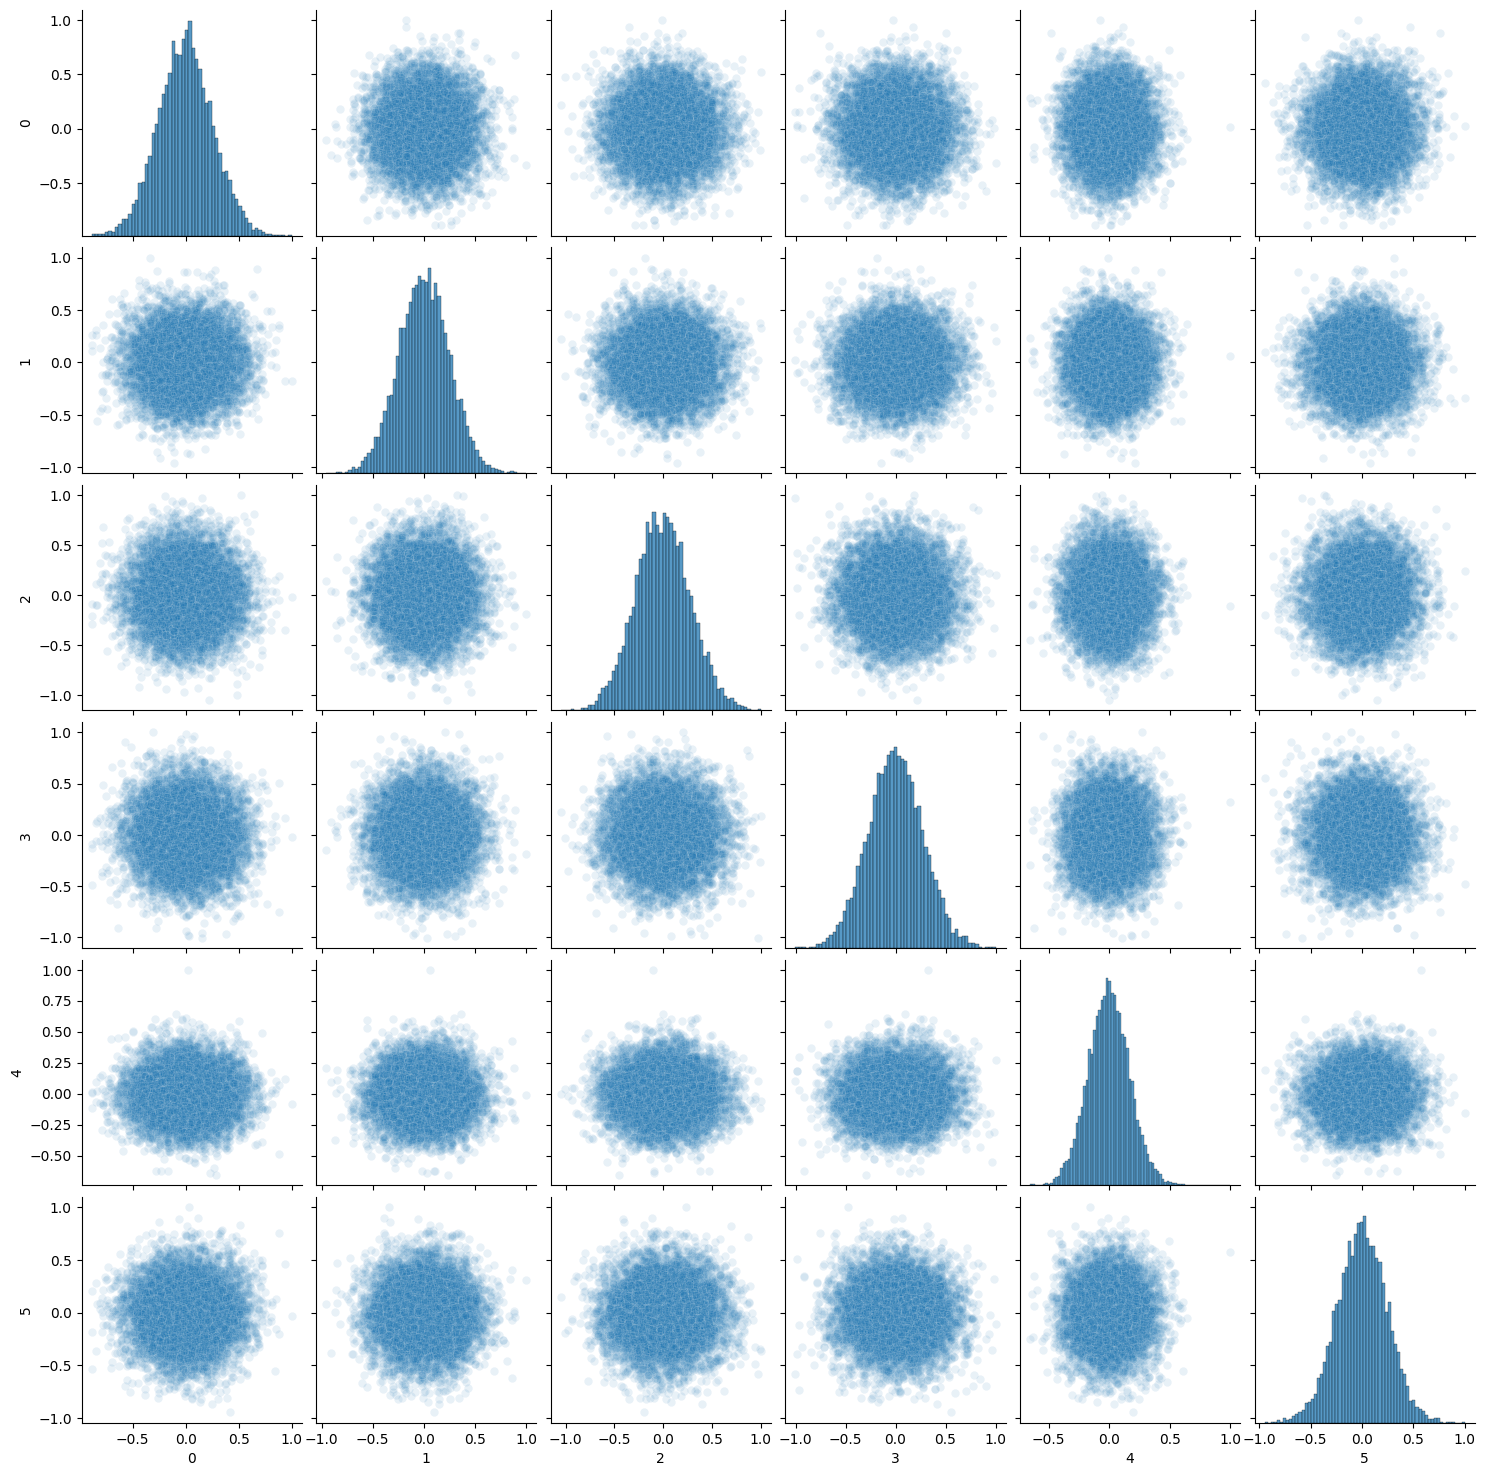

In [52]:
inds = list(range(31,37))
data = out_fun[:,10,inds].squeeze()
scale = np.max(data,axis=0)
data = data/scale
df = pd.DataFrame(data)
sns.pairplot(df,plot_kws={'alpha':0.1})